In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [2]:
import os
import pandas as pd
import numpy as np 

import torch
import cv2
torch.set_float32_matmul_precision('medium')

from nets import classification
from loaders.tt_dataset import TTDataModuleSeg, TrainTransformsFullSeg, EvalTransformsFullSeg

from sklearn.utils import class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
from nets.classification import EfficientNetV2SYOLTv2, EfficientnetV2s, EfficientnetV2sPatch
import torchvision
from torch.utils.data import DataLoader

from matplotlib.patches import Rectangle


2024-11-11 12:04:17.477672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 12:04:18.347722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [222]:
csv_train= '/CMF/data/lumargot/trachoma/B images one eye/csv/Pret_excluded_clean_fold4_test.csv'
csv_valid= '/CMF/data/lumargot/trachoma/B images one eye/csv/Pret_excluded_clean_fold4_test.csv'
csv_test= '/CMF/data/lumargot/trachoma/B images one eye/csv/Pret_excluded_clean_fold4_test.csv'
mount_point= '/CMF/data/lumargot/trachoma/B images one eye'
img_column= "img" 
seg_column= "seg" 
class_column= None
map = {'0':'Healthy', '1':'Bad', '2': 'Reject'}

In [223]:
df_train = pd.read_csv(csv_train) 
df_val = pd.read_csv(csv_valid)
df_test = pd.read_csv(csv_test)

train_transform = TrainTransformsFullSeg()
eval_transform = EvalTransformsFullSeg()


In [225]:
ttdata = TTDataModuleSeg(df_train, df_val, df_test, 
                         batch_size=1, 
                         num_workers=4, 
                         img_column=img_column, 
                         seg_column=seg_column, 
                         class_column=class_column, 
                         mount_point=mount_point, 
                         train_transform=train_transform, 
                         valid_transform=eval_transform, 
                         test_transform=eval_transform, 
                         drop_last=True)

ttdata.setup()

ds = ttdata.test_ds
test_load = ttdata.val_dataloader()

In [226]:
ds[0]

{'img': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'seg': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...

In [6]:
ckpt = '/CMF/data/lumargot/trachoma/output/patches/subset_models/rejection_class/HealthyXBadXReject/fold4/epoch=27-val_loss=0.36.ckpt'
mone = EfficientnetV2s.load_from_checkpoint(ckpt).cuda()
mone.eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.


EfficientnetV2s(
  (loss): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), pa

In [7]:
def compute_patch_size(seg, pad):
  seg = torch.Tensor(seg)
  shape = seg.shape[1:3]

  ij = torch.argwhere(seg.squeeze() !=0.)
  bb = torch.tensor([0, 0, 0, 0]) # xmin, ymin, xmax, ymax

  bb[0] = torch.clip(torch.min(ij[:,1]) - pad, 0, shape[1])
  bb[1] = torch.clip(torch.min(ij[:,0]) - pad, 0, shape[0])
  bb[2] = torch.clip(torch.max(ij[:,1]) + pad, 0, shape[1])
  bb[3] = torch.clip(torch.max(ij[:,0]) + pad, 0, shape[0])

  patch_w = (bb[2] - bb[0])/10

  patch_size = min(int(patch_w), 64)
  return patch_size, bb


In [147]:
def show_croped_seg_img(img_cropped, seg_cropped, x_axis, y_axis, pad):

  fig = plt.figure()
  ax = fig.add_subplot(1,2)
  ax[0].imshow(img_cropped.permute(1,2,0))
  plt.plot(x_axis, y_axis)

  for (x,y) in zip(x_axis, y_axis):
    rect = Rectangle(xy=(x-pad, y-pad), width=2*pad, height=2*pad,
                    fill=False, linewidth=2, color='red')

    ax[0].add_patch(rect)

  plt.xlabel("x - axis")
  plt.ylabel("y - axis")    

  ax[1].imshow(seg_cropped)
  plt.show()

In [149]:
def show_patches_from_polyfit(seg_cropped, pad=29, step=20, show=True, img_cropped=None):
  y, x = np.where(seg_cropped[0] == 3)	

  z = np.polyfit(x, y, 3)
  poly = np.poly1d(z)

  x_axis = np.arange(pad, seg_cropped.shape[-1]-pad , step=step)
  y_axis = poly(x_axis)

  if show:

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(img_cropped.permute(1,2,0))
    plt.plot(x_axis, y_axis)

    for (x,y) in zip(x_axis, y_axis):
      rect = Rectangle(xy=(x-pad, y-pad), width=2*pad, height=2*pad,
                      fill=False, linewidth=2, color='red')

      ax.add_patch(rect)

    plt.xlabel("x - axis")
    plt.ylabel("y - axis")    
    plt.show()

  return x_axis, y_axis


## extract patches from x,y
def extract_patches(img_cropped, x_list, y_list, patch_sz):
    patches = []
    for (x_center, y_center) in zip(x_list,y_list):
        y_center=int(y_center)
        y_center = max(patch_sz, y_center)
        y_center = min(img_cropped.shape[-2] - patch_sz, y_center)

        x_center = max(patch_sz, x_center)
        x_center = min(img_cropped.shape[-1] - patch_sz, x_center)
        
        patch = img_cropped[:,y_center-patch_sz:y_center+patch_sz, x_center-patch_sz:x_center+patch_sz]
        patches.append(patch)
    return torch.stack(patches, dim=0)


In [220]:
len(ds)

279

In [233]:
np.arange(279)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


5 3 torch.Size([9, 3, 512, 512])


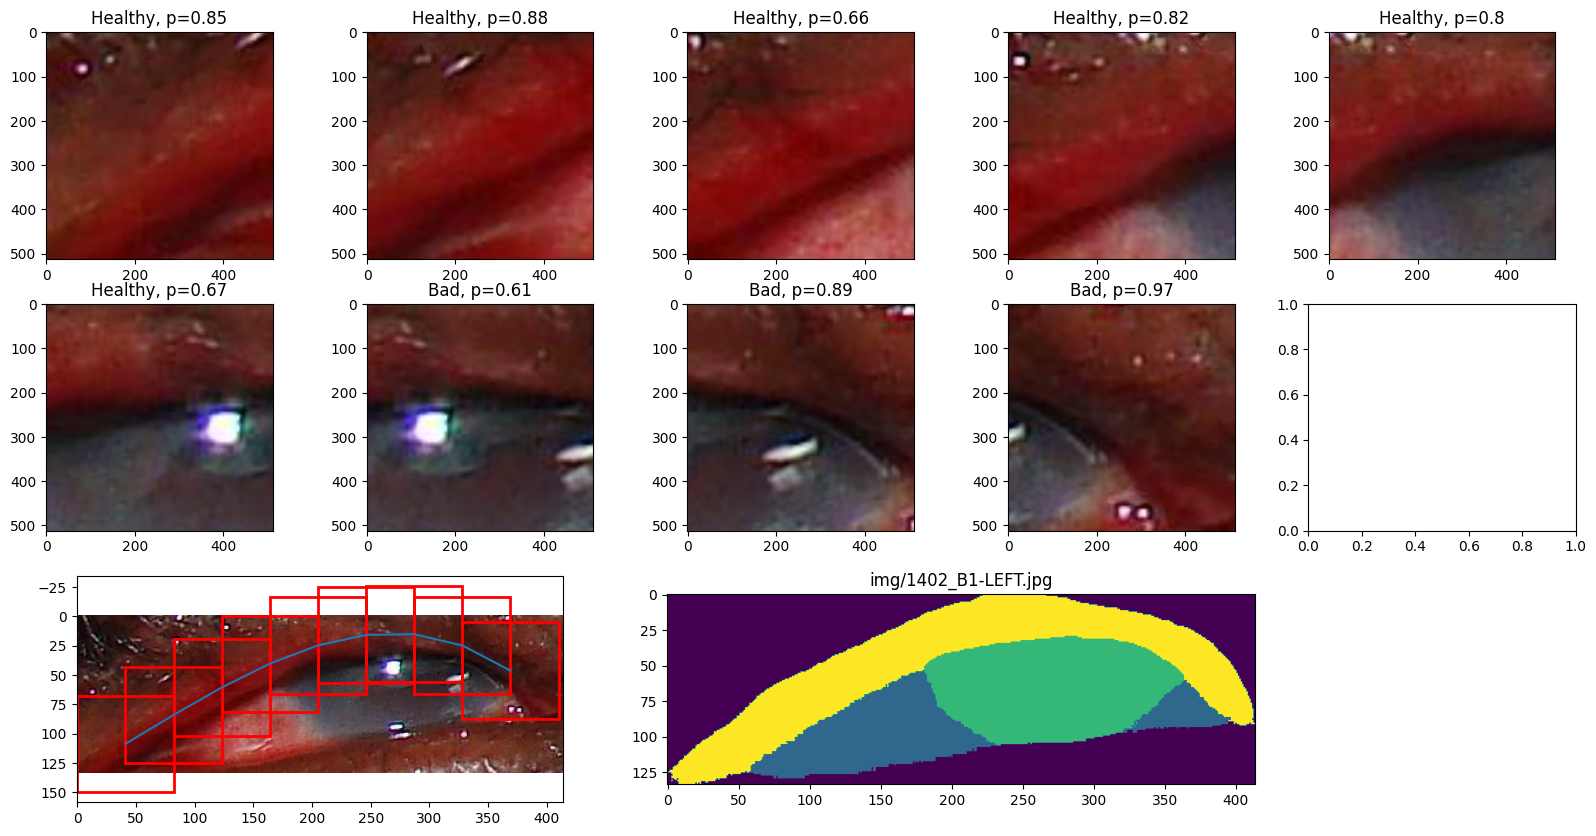

5 3 torch.Size([9, 3, 512, 512])


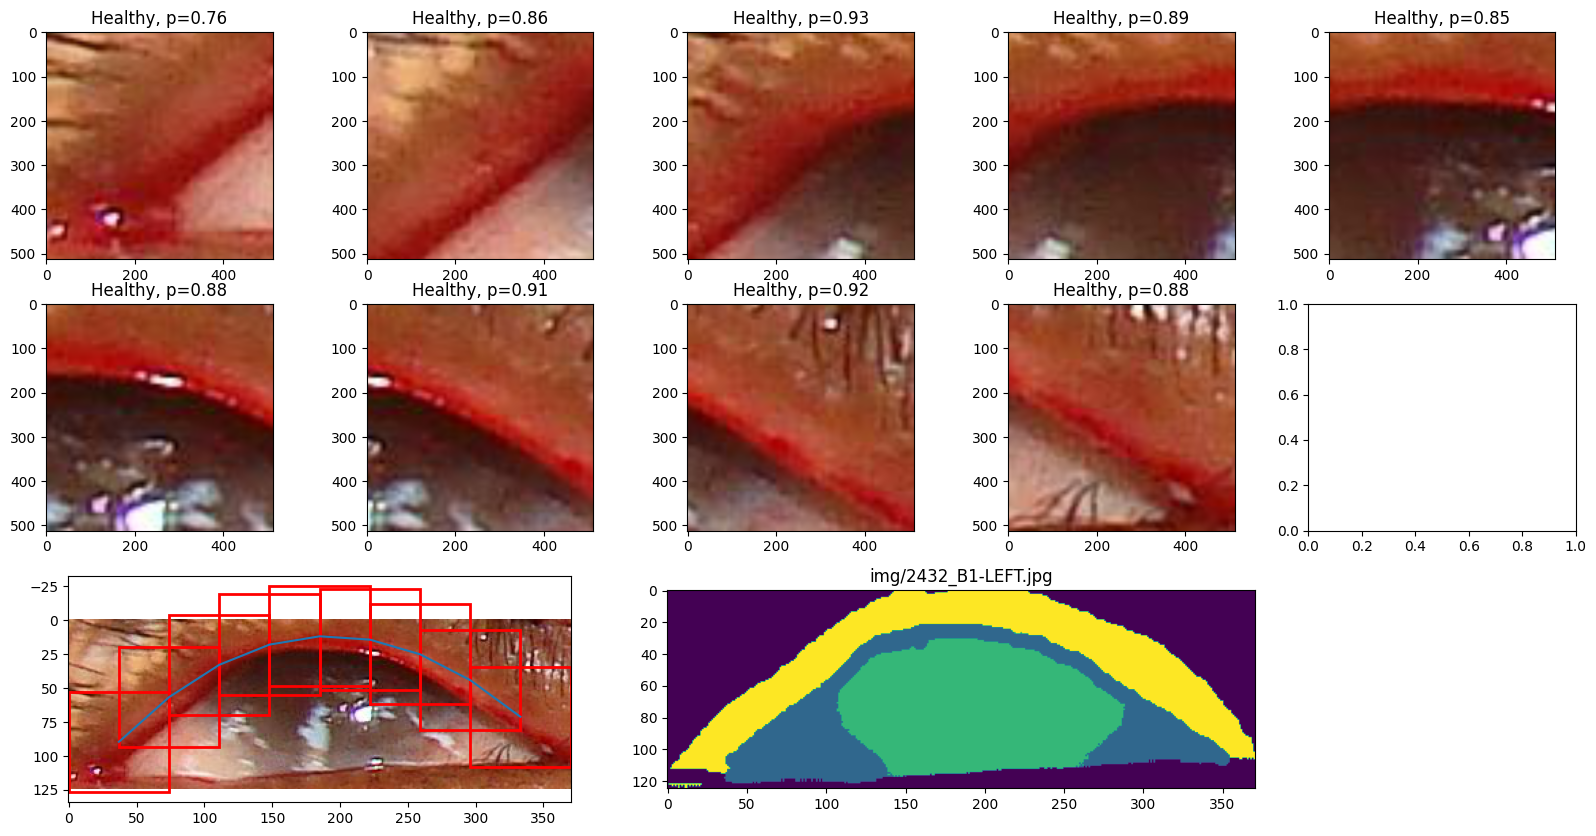

5 3 torch.Size([9, 3, 512, 512])


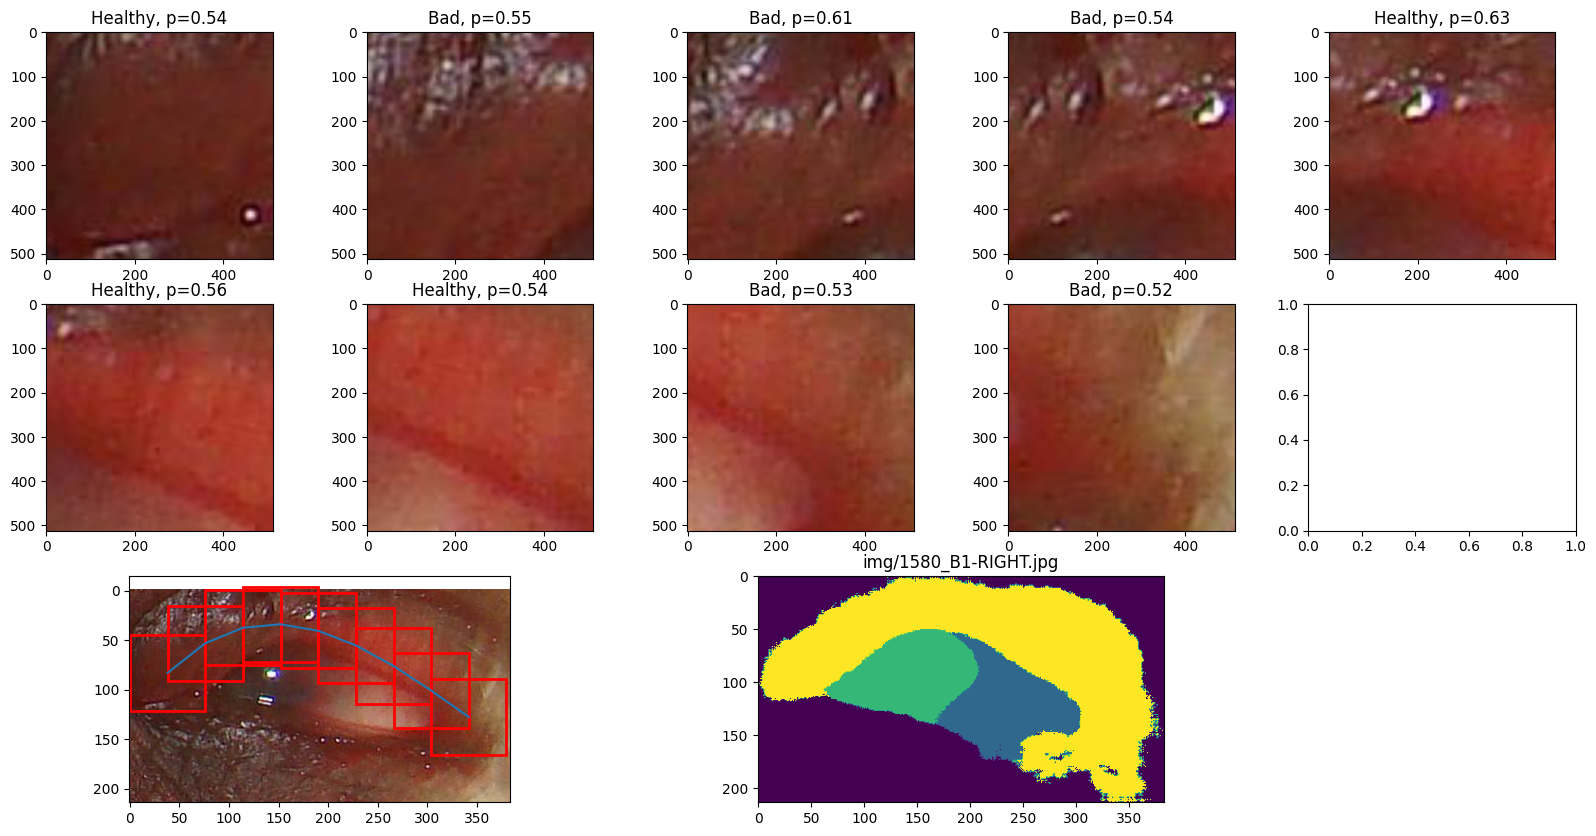

5 3 torch.Size([9, 3, 512, 512])


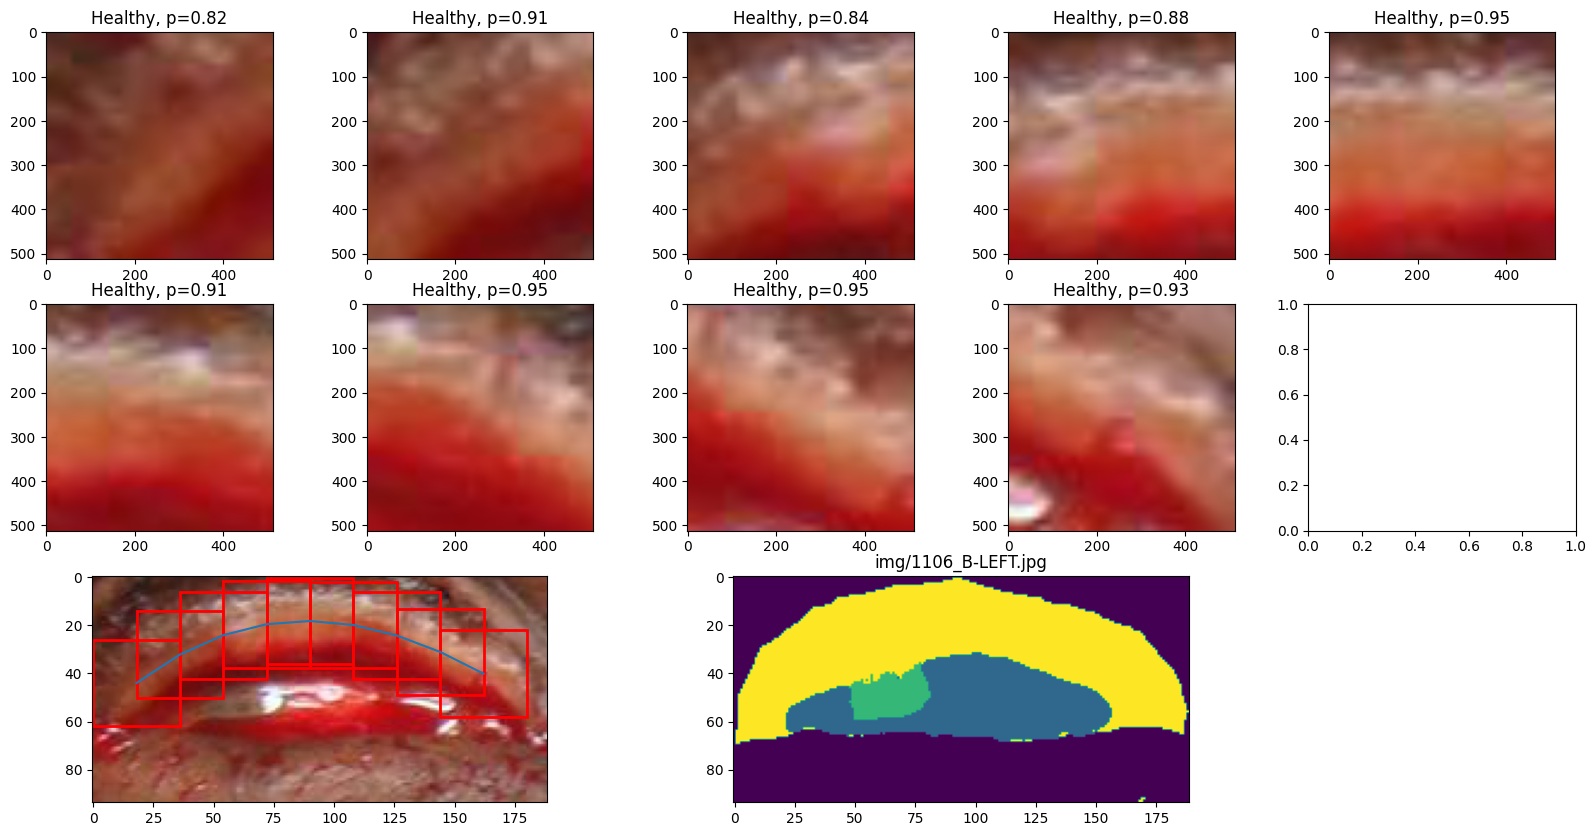

5 3 torch.Size([9, 3, 512, 512])


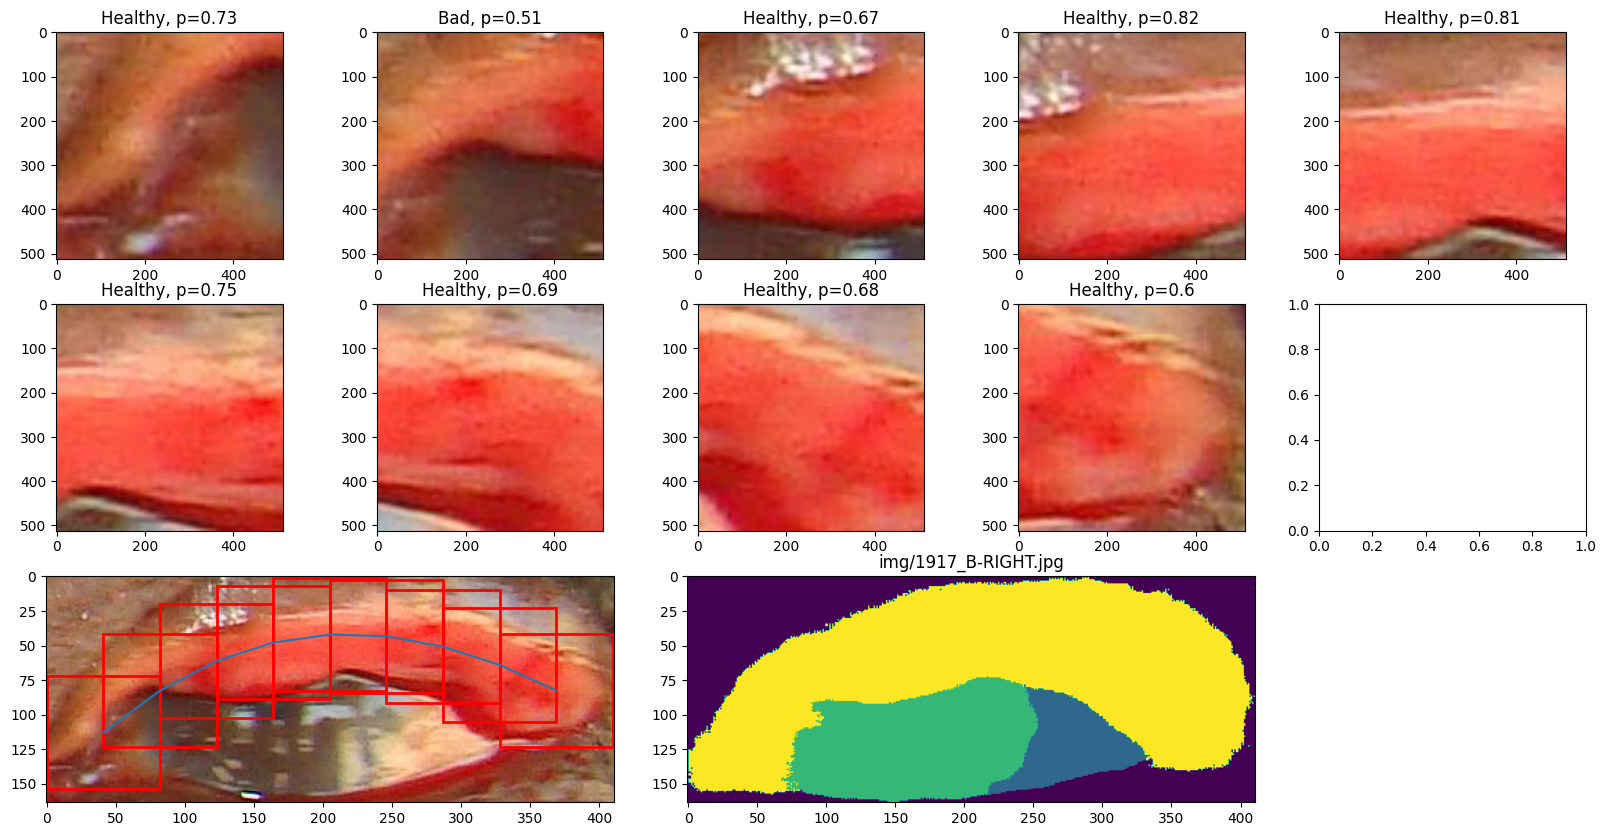

5 3 torch.Size([9, 3, 512, 512])


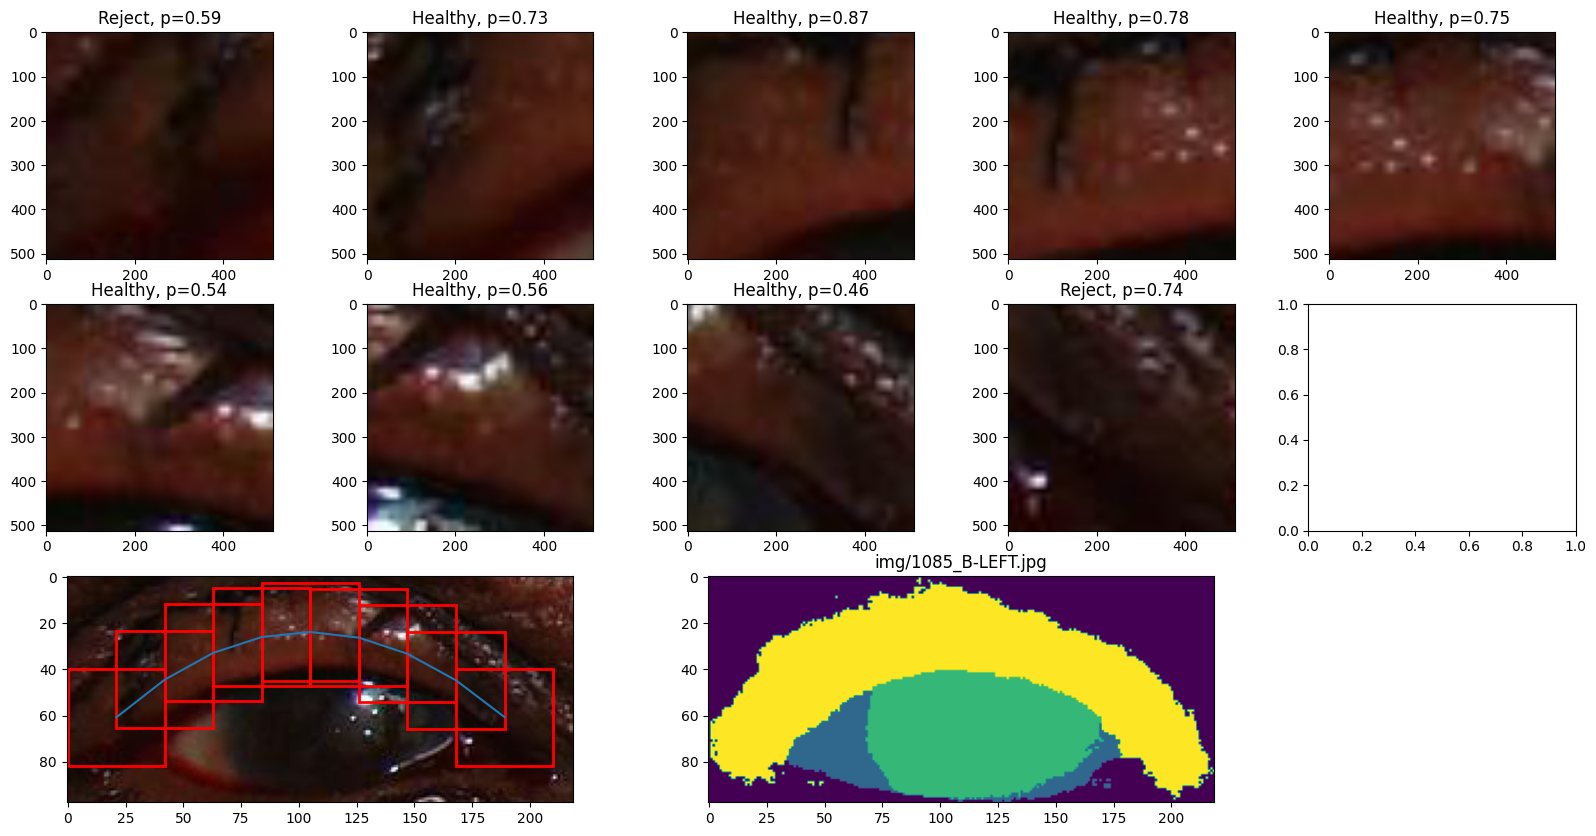

5 3 torch.Size([8, 3, 512, 512])


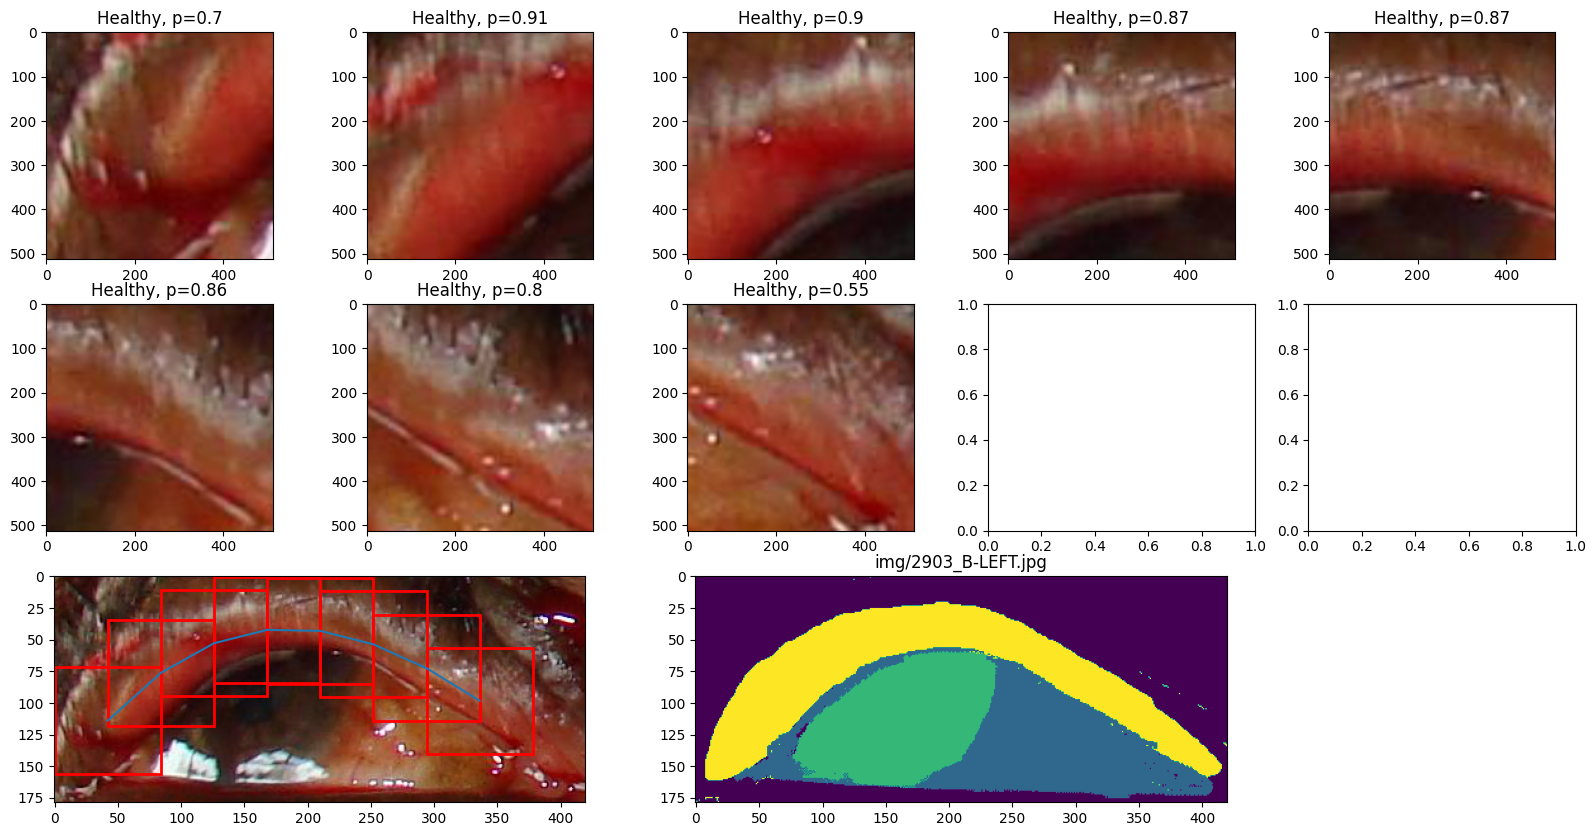

5 3 torch.Size([9, 3, 512, 512])


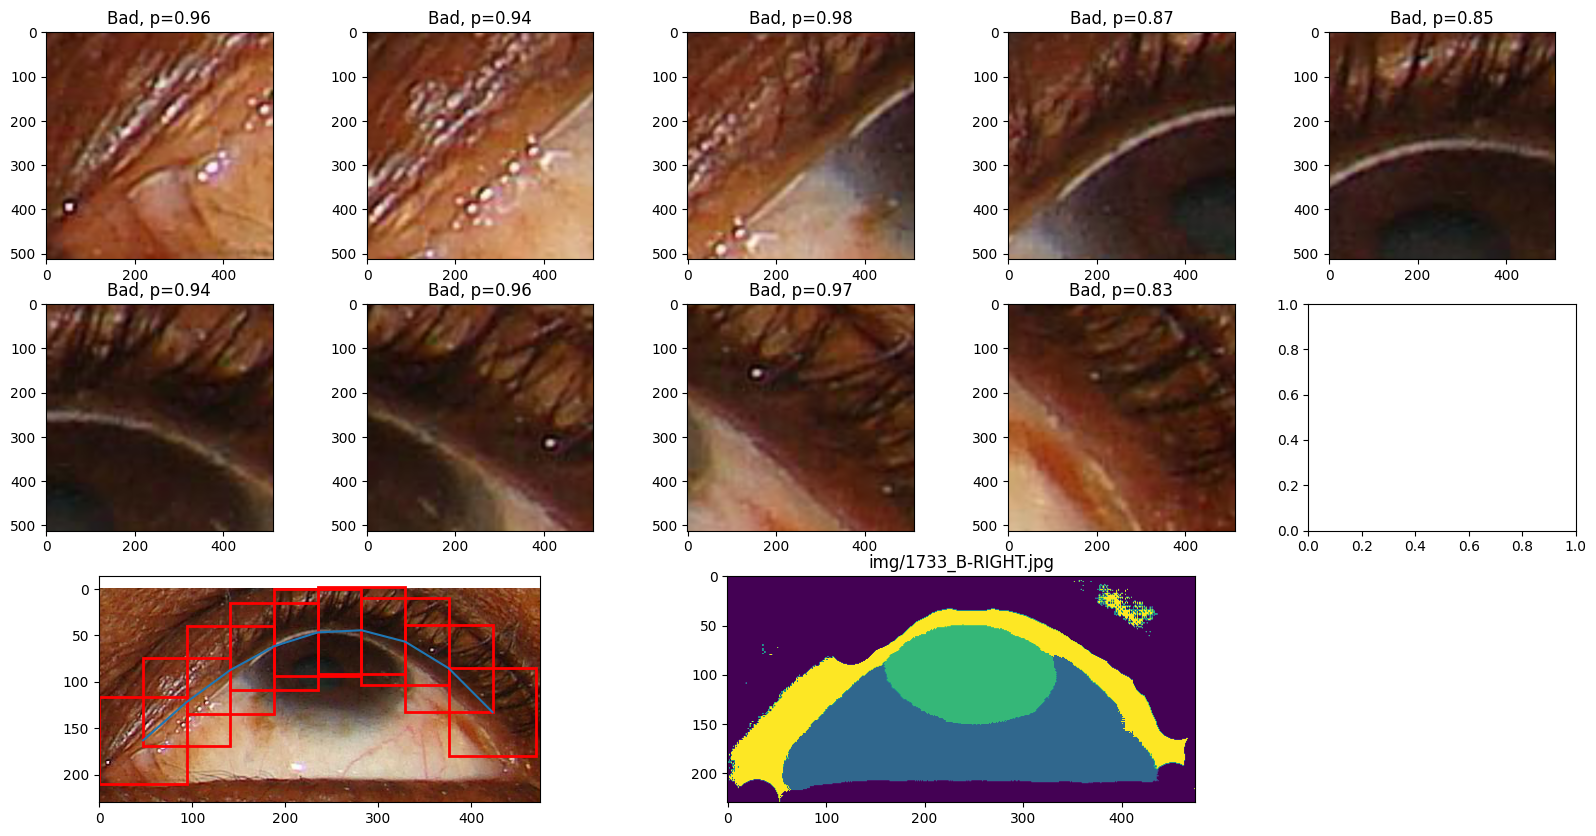

5 3 torch.Size([9, 3, 512, 512])


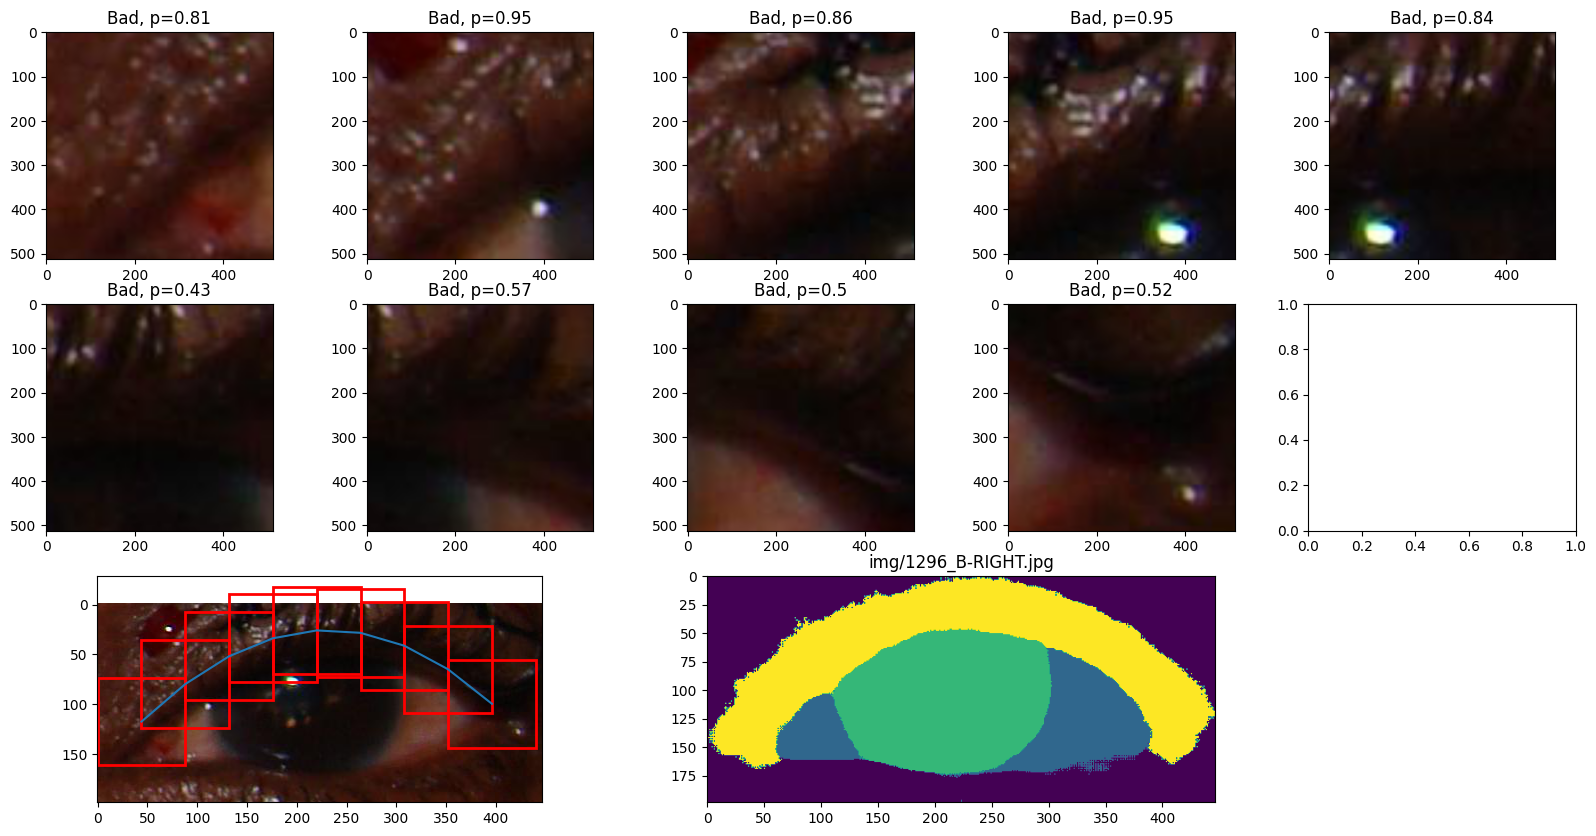

5 3 torch.Size([9, 3, 512, 512])


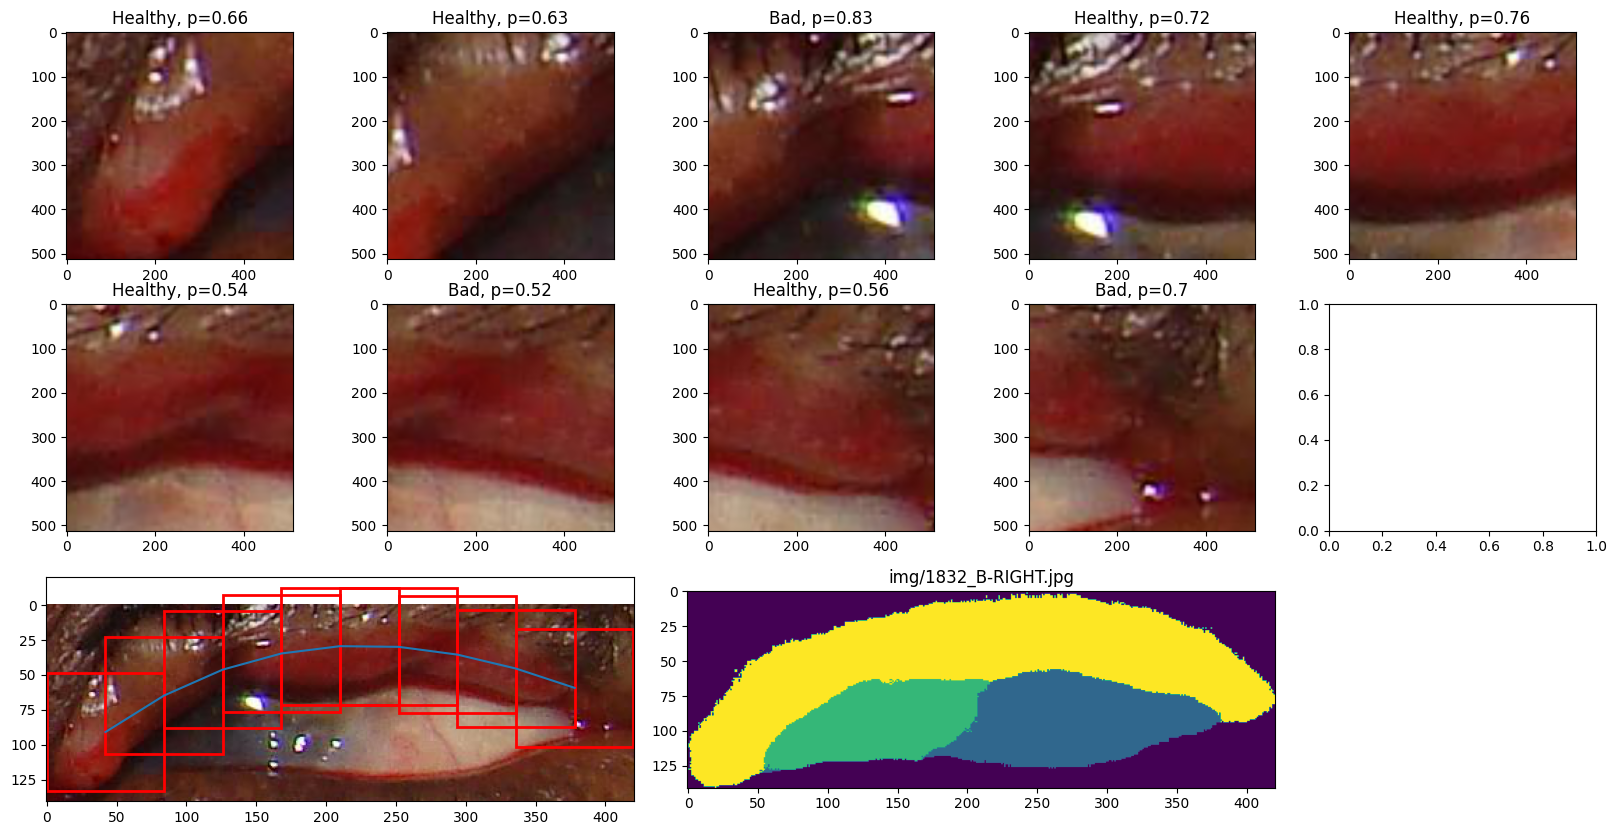

In [234]:
indices = np.arange(len(ds))

for idx in indices[30:40] :
  imgs, segs = ds[idx]['img'].unsqueeze(0), ds[idx]['seg'].unsqueeze(0)
  
  ## ------------- preprocess  -------------##
  patch_sz, bb = compute_patch_size(segs[0], pad=1)
  seg_cropped = segs[0,:, bb[1]:bb[3], bb[0]: bb[2]]
  img_cropped = imgs[0,: ,bb[1]:bb[3], bb[0]: bb[2]]
  
  eyelid = seg_cropped.clone()
  eyelid[eyelid != 3] = 0

  ## ------------- compute patches -------------##
  x_axis,y_axis = show_patches_from_polyfit(eyelid, pad=patch_sz, step=int(patch_sz), show=False)
  patches = extract_patches(img_cropped, x_axis,y_axis, patch_sz=patch_sz)
  resize_img = torchvision.transforms.Resize(512)
  patches = resize_img(patches)

  ## ------------- prediction -------------##

  output = mone(patches.cuda())

  vals, labels = torch.max(output, dim=1)
  labels = labels.cpu().numpy()
  vals = vals.detach().cpu().numpy()

  ## ------------- display of patches + prediction -------------##

  ncols=5
  nrows = int(patches.shape[0]/ncols) +2 # 1 for rounding, 1 for cropped_img
  print(ncols, nrows, patches.shape)
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout=None, figsize=(20,10))
  for i in range(patches.shape[0]):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(patches[i].permute(1,2,0))
    predicted_class = map[str(labels[i])]
    prob = str(np.around(vals[i], 2))

    plt.title(f"{predicted_class}, p={prob}")

  ## ------------- show crop image with cubes -------------##
  gs = axs[-1, -1].get_gridspec()
  for ax in axs[-1,:]:
      ax.remove()
  axbig = fig.add_subplot(gs[-1,:2])
  axbig.imshow(img_cropped.permute(1,2,0))
  axbig.plot(x_axis, y_axis)


  for (x,y) in zip(x_axis, y_axis):
    rect = Rectangle(xy=(x-patch_sz, y-patch_sz), width=2*patch_sz, height=2*patch_sz,
                    fill=False, linewidth=2, color='red')
    axbig.add_patch(rect)

  axbig = fig.add_subplot(gs[-1,2:4])
  axbig.imshow(seg_cropped[0])

  plt.title(ds.data.df.iloc[idx]['img'])


  plt.show()